In [1]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import contextily as cx

In [2]:
ejblocks = gpd.read_file("../data/joins/ejblocks.shp.zip")

## MANOVA

In [3]:
from statsmodels.multivariate.manova import MANOVA
fit = MANOVA.from_formula('AC_5 + AC_10 + AC_15 + AC_20 + AC_30 + AC_45 + AC_60 ~ TC', data=ejblocks)
print(fit.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.9795 7.0000 47130.0000 141.2455 0.0000
         Pillai's trace 0.0205 7.0000 47130.0000 141.2455 0.0000
 Hotelling-Lawley trace 0.0210 7.0000 47130.0000 141.2455 0.0000
    Roy's greatest root 0.0210 7.0000 47130.0000 141.2455 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
            TC           Value  Num DF   Den DF   F Value Pr > F
----------------------------------------------------------------
           Wilks' lambda 0.9988 7.0000 47130.0000  8.2736 0.0000
          Pillai's trace 0.0012 7.0000 47130.

## Creating Boolean Columns

In [4]:
cols = ["AC_5","AC_10","AC_15","AC_20","AC_30","AC_45","AC_60"]
cols_bools = [col+"_bool" for col in cols]
cols_pops = [col+"_pop" for col in cols]

In [5]:
ejblocks["TC_bool"] = ejblocks["TC"] > 0
for i in range(len(cols)):
    if i == 0:
        ejblocks[cols_bools[i]] = ejblocks[cols[i]] > 0
    else:
        ejblocks[cols_bools[i]] = (ejblocks[cols[i]] > 0) | ejblocks[cols_bools[i-1]]
    ejblocks[cols_pops[i]] = np.where(ejblocks[cols_bools[i]], ejblocks["P1_001N"], 0)

In [6]:
ejblocks[cols_bools].head(10)

,AC_5_bool,AC_10_bool,AC_15_bool,AC_20_bool,AC_30_bool,AC_45_bool,AC_60_bool
0,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True
3,False,True,True,True,True,True,True
4,False,True,True,True,True,True,True
5,False,True,True,True,True,True,True
6,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True
9,True,True,True,True,True,True,True


## 10-Minute Walk Analysis

In [7]:
tab = pd.crosstab(ejblocks["TC_bool"], np.logical_not(ejblocks["AC_10_bool"]), ejblocks["P1_001N"], aggfunc='sum')
table = sm.stats.Table2x2(tab)

print("Total Values:", int(np.sum(tab.values)))
print(table.table_orig)
print(table.summary())
print(table.test_nominal_association())
print("Probability of No Conserved Land w/in 10-Minute Walk:", table.marginal_probabilities[1])

Total Values: 1362359
AC_10_bool     False     True 
AC_10_bool                    
False       257017.0  733056.0
True         77683.0  294603.0
               Estimate   SE   LCB   UCB  p-value
-------------------------------------------------
Odds ratio        1.330       1.318 1.342   0.000
Log odds ratio    0.285 0.005 0.276 0.294   0.000
Risk ratio        1.244       1.235 1.253   0.000
Log risk ratio    0.218 0.004 0.211 0.225   0.000
-------------------------------------------------
df          1
pvalue      0.0
statistic   3786.722929514167
Probability of No Conserved Land w/in 10-Minute Walk: AC_10_bool
False    0.245677
True     0.754323
dtype: float64


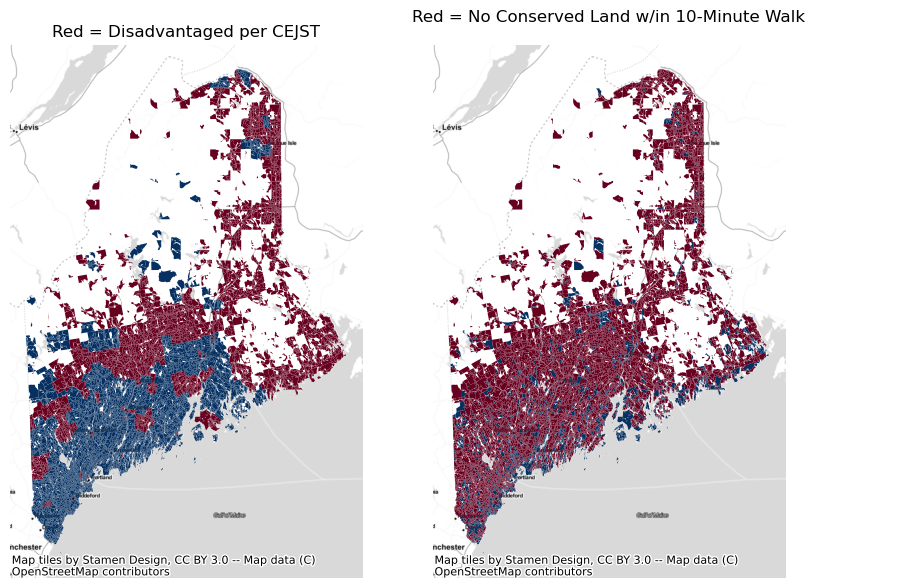

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10,8))
ejblocks[ejblocks["P1_001N"] > 0].plot("TC_bool", cmap="RdBu_r", ax=axs[0])
ejblocks[ejblocks["P1_001N"] > 0].plot("AC_10_bool", cmap="RdBu", ax=axs[1])
axs[0].set_title("Red = Disadvantaged per CEJST")
axs[1].set_title("Red = No Conserved Land w/in 10-Minute Walk")
axs[0].axis("off")
axs[1].axis("off")
cx.add_basemap(axs[0], source=cx.providers.Stamen.TonerLite)
cx.add_basemap(axs[1], source=cx.providers.Stamen.TonerLite)

## 60-Minute Walk Analysis

In [10]:
tab = pd.crosstab(ejblocks["TC_bool"], np.logical_not(ejblocks["AC_60_bool"]), ejblocks["P1_001N"], aggfunc='sum')
table = sm.stats.Table2x2(tab)

print("Total Values:", int(np.sum(tab.values)))
print(table.table_orig)
print(table.summary())
print(table.test_nominal_association())
print(*table.marginal_probabilities)
print("Probability of No Conserved Land w/in 60-Minute Walk:", table.marginal_probabilities[1])

Total Values: 1362359
AC_60_bool     False     True 
AC_60_bool                    
False       896336.0   93737.0
True        271449.0  100837.0
               Estimate   SE   LCB   UCB  p-value
-------------------------------------------------
Odds ratio        3.552       3.517 3.587   0.000
Log odds ratio    1.268 0.005 1.258 1.277   0.000
Risk ratio        1.242       1.239 1.244   0.000
Log risk ratio    0.216 0.001 0.214 0.218   0.000
-------------------------------------------------
df          1
pvalue      0.0
statistic   68597.98863767541
AC_60_bool
False    0.726734
True     0.273266
dtype: float64 AC_60_bool
False    0.857179
True     0.142821
dtype: float64
Probability of No Conserved Land w/in 60-Minute Walk: AC_60_bool
False    0.857179
True     0.142821
dtype: float64


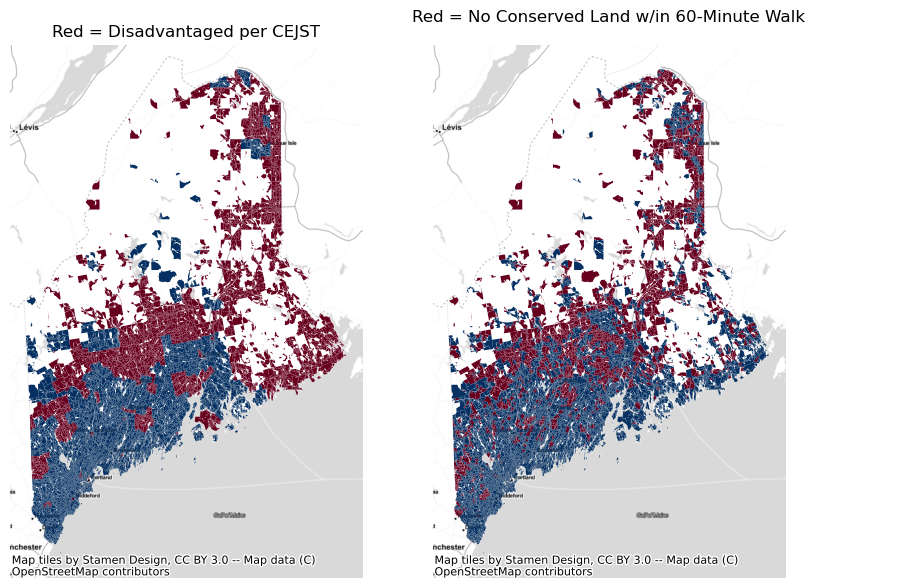

In [11]:
fig, axs = plt.subplots(1,2, figsize=(10,8))
ejblocks[ejblocks["P1_001N"] > 0].plot("TC_bool", cmap="RdBu_r", ax=axs[0])
ejblocks[ejblocks["P1_001N"] > 0].plot("AC_60_bool", cmap="RdBu", ax=axs[1])
axs[0].set_title("Red = Disadvantaged per CEJST")
axs[1].set_title("Red = No Conserved Land w/in 60-Minute Walk")
axs[0].axis("off")
axs[1].axis("off")
cx.add_basemap(axs[0], source=cx.providers.Stamen.TonerLite)
cx.add_basemap(axs[1], source=cx.providers.Stamen.TonerLite)

## Checking Population and Population Density Effects

In [12]:
fit = MANOVA.from_formula('AC_10 + AC_60 ~ TC + P1_001N + POPDENSE + TC*POPDENSE + TC*P1_001N', data=ejblocks)
print(fit.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.9939 2.0000 43172.0000 132.8277 0.0000
         Pillai's trace 0.0061 2.0000 43172.0000 132.8277 0.0000
 Hotelling-Lawley trace 0.0062 2.0000 43172.0000 132.8277 0.0000
    Roy's greatest root 0.0062 2.0000 43172.0000 132.8277 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
            TC           Value  Num DF   Den DF   F Value Pr > F
----------------------------------------------------------------
           Wilks' lambda 0.9993 2.0000 43172.0000 15.9424 0.0000
          Pillai's trace 0.0007 2.0000 43172.

## Plots

In [13]:
ejblocks["white_per"] = ejblocks["P1_003N"] / ejblocks["P1_001N"]
ejblocks["hisp_per"] = ejblocks["P2_002N"] / ejblocks["P2_001N"]
ejblocks["white_50"] = ejblocks["white_per"] > ejblocks["white_per"].describe()["50%"]
ejblocks["hisp_75"] = ejblocks["hisp_per"] > ejblocks["hisp_per"].describe()["75%"]

Text(0.5, 1.0, '"Disadvantaged" Population is Less Likely to Have Access')

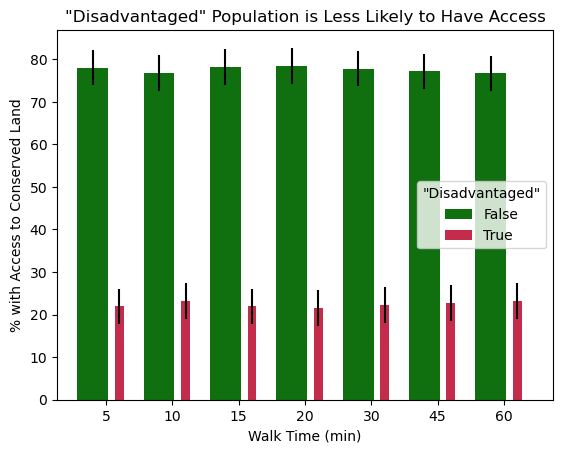

In [14]:
def plot_by_group(groupby_col = "TC_bool", r=False):
    if r:
        palette = {False:"crimson", True:"green"}
    else:
        palette = {True:"crimson", False:"green"}
    g = ejblocks.groupby([groupby_col])[cols_pops]
    p = g.sum() / g.sum().sum()
    percents = (p * 100).melt(ignore_index=False, value_name="mean").reset_index()
    percents_std= np.sqrt(p*(1-p)*100).melt(ignore_index=False, value_name="std").reset_index()
    percents = pd.concat([percents, percents_std["std"]], axis=1)
    ax = sns.barplot(
        percents,
        x="variable",
        y="mean",
        hue=groupby_col,
        errorbar=None,
        palette=palette
    )
    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
    y_coords = [p.get_height() for p in ax.patches]
    ax.errorbar(x=x_coords, y=y_coords, yerr=percents["std"].values, fmt="none", c="k")
    ax.set_title("Percent of Population with Conserved Land within Walk Times")
    ax.set_ylabel("% with Access to Conserved Land")
    ax.set_xlabel("Walk Time (min)")
    ax.set_xticklabels([label.get_text().split("_")[1] for label in ax.get_xticklabels()])
    ax.legend(title="\"Disadvantaged\"")
    widths = 0.6 * p.values.ravel()
    for bar, newwidth in zip(ax.patches, widths):
        x = bar.get_x()
        width = bar.get_width()
        center = x + width/2.
        bar.set_x(center - newwidth/2.)
        bar.set_width(newwidth)
    return ax

ax = plot_by_group("TC_bool")
ax.legend(title="\"Disadvantaged\"", loc='center right')
ax.set_title("\"Disadvantaged\" Population is Less Likely to Have Access")

Text(0.5, 1.0, 'Blocks with Higher % White Population are More Likely to have Access')

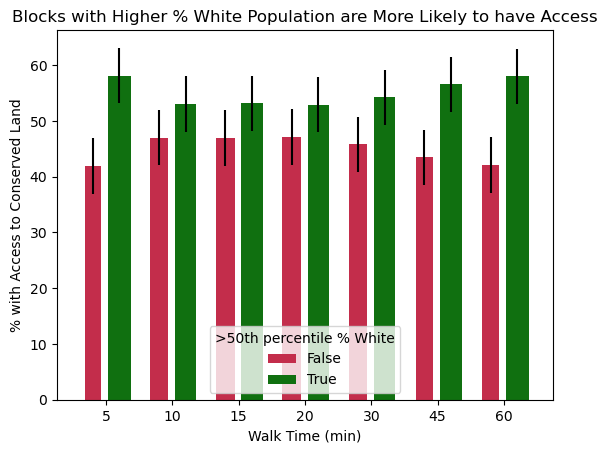

In [15]:
ax = plot_by_group("white_50", r=True)
ax.legend(title=">50th percentile % White", loc='lower center')
ax.set_title("Blocks with Higher % White Population are More Likely to have Access")

Text(0.5, 1.0, 'Blocks with Highest % Hispanic or Latino are Less Likely to Have Access')

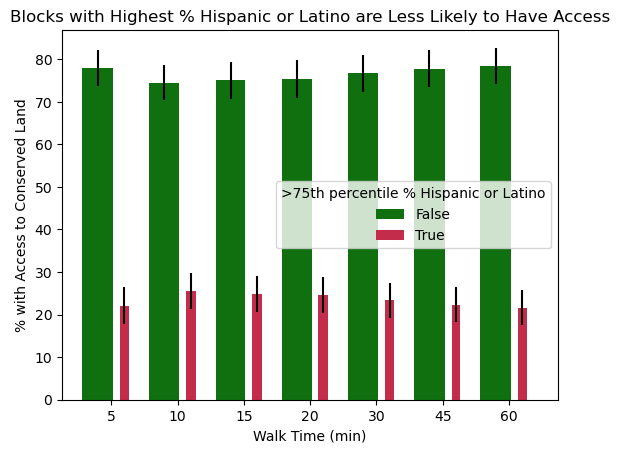

In [16]:
ax = plot_by_group("hisp_75", False)
ax.legend(title=">75th percentile % Hispanic or Latino", loc='center right')
ax.set_title("Blocks with Highest % Hispanic or Latino are Less Likely to Have Access")

## Closest Conserved Lands

In [19]:
melt = ejblocks[ejblocks["ALAND20"] > 0].melt(id_vars=["GEOID20","geometry"],value_vars=cols_bools)
melt["nearest"] = np.where(melt["value"], melt["variable"].apply(lambda s: int(s.split("_")[1])), 60)
melt = gpd.GeoDataFrame(melt.groupby("GEOID20").agg({
    "geometry":"first",
    "nearest":"min"
}))

Text(0.5, 1.0, 'Minimum Walk Time to Conserved Land')

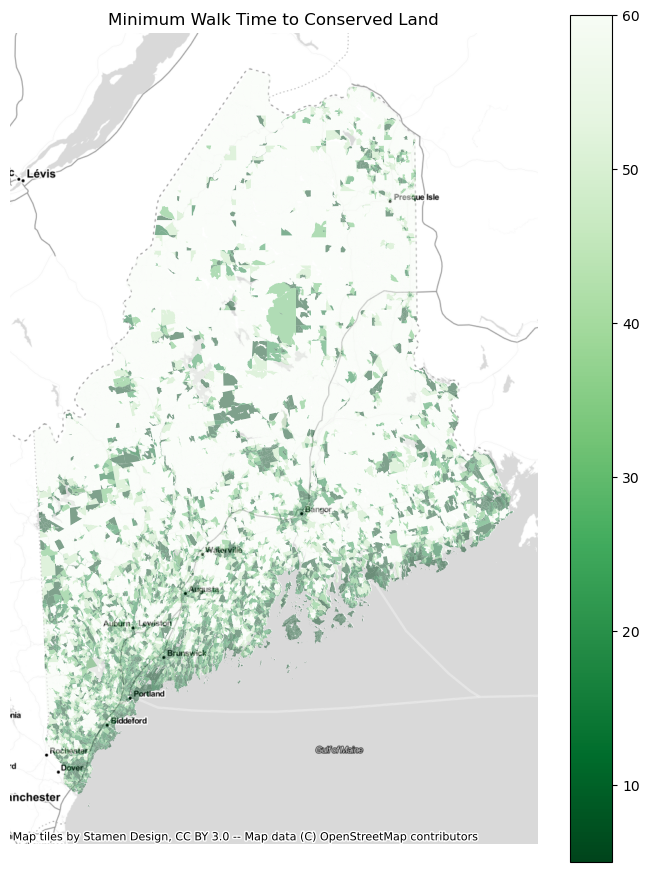

In [20]:
fig, ax = plt.subplots(figsize=(8.5,11))
melt.plot("nearest", ax=ax, cmap="Greens_r", legend=True, alpha=0.5)
ax.axis("off")
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
ax.set_title("Minimum Walk Time to Conserved Land")